# Pegasos Quantum Support Vector Classifier

There's another SVM based algorithm that benefits from the quantum kernel method. Here, we introduce an implementation of a another classification algorithm, which is an alternative version to the `QSVC` available in Qiskit Machine Learning and shown in the ["Quantum Kernel Machine Learning"](./03_quantum_kernel.ipynb) tutorial. This classification algorithm implements the Pegasos algorithm from the paper "Pegasos: Primal Estimated sub-GrAdient SOlver for SVM" by Shalev-Shwartz et al., see: https://home.ttic.edu/~nati/Publications/PegasosMPB.pdf.

This algorithm is an alternative to the dual optimization from the `scikit-learn` package, benefits from the kernel trick, and yields a training complexity that is independent of the size of t|he training set. Thus, the `PegasosQSVC` is expected to train faster than QSVC for sufficiently large training sets.

The algorithm can be used as direct replacement of `QSVC` with some hyper-parameterization.

Let's generate some data:

In [1]:
# Download all libraries before run notebook
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_machine_learning

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 9.5 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.42.1-py3-none-any.whl size=12942 sha256=8c7578985fa9948e990adc4180fe897f2f8e3818d00e29f822b7efb8f8ee3d85
  Stored in directory: /root/.cache/pip/wheels/91/da/30/d31269da763cce6fd356f8385f

In [2]:
from sklearn.datasets import make_blobs

# example dataset
features, labels = make_blobs(n_samples=20, n_features=2, centers=2, random_state=3, shuffle=True)

We pre-process the data to ensure compatibility with the rotation encoding and split it into the training and test datasets.

In [3]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(features)

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=15, shuffle=False
)

We have two features in the dataset, so we set a number of qubits to the number of features in the dataset.

Then we set $\tau$ to the number of steps performed during the training procedure. Please note that, there is no early stopping criterion in the algorithm. The algorithm iterates over all $\tau$ steps.

And the last one is the hyperparameter $C$. This is a positive regularization parameter. The strength of the regularization is inversely proportional to $C$. Smaller $C$ induce smaller weights which generally helps preventing overfitting. However, due to the nature of this algorithm, some of the computation steps become trivial for larger $C$. Thus, larger $C$ improve the performance of the algorithm drastically. If the data is linearly separable in feature space, $C$ should be chosen to be large. If the separation is not perfect, $C$ should be chosen smaller to prevent overfitting.

In [4]:
# number of qubits is equal to the number of features
num_qubits = 2

# number of steps performed during the training procedure
tau = 100

# regularization parameter
C = 1000

The algorithm will run using:

- The default fidelity instantiated in `FidelityQuantumKernel`
- A quantum kernel created from `ZFeatureMap`

In [5]:
from qiskit import BasicAer
from qiskit.circuit.library import ZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.kernels import FidelityQuantumKernel

algorithm_globals.random_seed = 12345

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)

qkernel = FidelityQuantumKernel(feature_map=feature_map)

The implementation `PegasosQSVC` is compatible with the `scikit-learn` interfaces and has a pretty standard way of training a model. In the constructor we pass parameters of the algorithm, in this case there are a regularization hyper-parameter $C$ and a number of steps.

Then we pass training features and labels to the `fit` method, which trains a models and returns a fitted classifier.

Afterwards, we score our model using test features and labels.

In [6]:
from qiskit_machine_learning.algorithms import PegasosQSVC

pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

# training
pegasos_qsvc.fit(train_features, train_labels)

# testing
pegasos_score = pegasos_qsvc.score(test_features, test_labels)
print(f"PegasosQSVC classification test score: {pegasos_score}")

PegasosQSVC classification test score: 1.0


For visualization purposes we create a mesh grid of a predefined step that spans our minimum and maximum values we applied in MinMaxScaler. We also add some margin to the grid for better representation of the training and test samples.

In [7]:
grid_step = 0.2
margin = 0.2
grid_x, grid_y = np.meshgrid(
    np.arange(-margin, np.pi + margin, grid_step), np.arange(-margin, np.pi + margin, grid_step)
)

We convert the grid to the shape compatible with the model, the shape should be `(n_samples, n_features)`.
Then for each grid point we predict a label. In our case predicted labels will be used for coloring the grid.

In [8]:
meshgrid_features = np.column_stack((grid_x.ravel(), grid_y.ravel()))
meshgrid_colors = pegasos_qsvc.predict(meshgrid_features)

Finally, we plot our grid according to the labels/colors we obtained from the model. We also plot training and test samples.

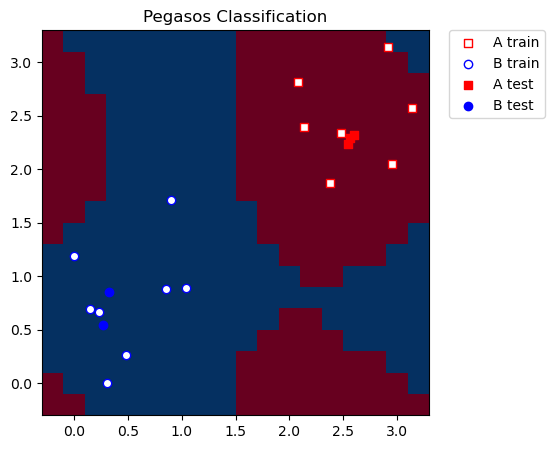

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
meshgrid_colors = meshgrid_colors.reshape(grid_x.shape)
plt.pcolormesh(grid_x, grid_y, meshgrid_colors, cmap="RdBu", shading="auto")

plt.scatter(
    train_features[:, 0][train_labels == 0],
    train_features[:, 1][train_labels == 0],
    marker="s",
    facecolors="w",
    edgecolors="r",
    label="A train",
)
plt.scatter(
    train_features[:, 0][train_labels == 1],
    train_features[:, 1][train_labels == 1],
    marker="o",
    facecolors="w",
    edgecolors="b",
    label="B train",
)

plt.scatter(
    test_features[:, 0][test_labels == 0],
    test_features[:, 1][test_labels == 0],
    marker="s",
    facecolors="r",
    edgecolors="r",
    label="A test",
)
plt.scatter(
    test_features[:, 0][test_labels == 1],
    test_features[:, 1][test_labels == 1],
    marker="o",
    facecolors="b",
    edgecolors="b",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Pegasos Classification")
plt.show()